<a href="https://colab.research.google.com/github/ShabnaIlmi/Bank-Marketing-Random-Forest-and-Neural-Networks/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing necessary libraries**

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading the dataset**

In [ ]:
# Loading the dataset with the proper delimiter (semicolon)
data = pd.read_csv('/content/drive/MyDrive/Bank-Marketing-Random-Forest-and-Neural-Networks/bank-additional-full.csv', delimiter=';')

In [ ]:
# Displaying the data contained within the dataset
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# **Data Preprocessing**

**Handling the target variable**

In [ ]:
# 1. Handling the target variable
data['y'] = data['y'].map({'yes': 1, 'no': 0})
X = data.drop(columns=['y'])
y = data['y']

In [ ]:
# 2. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

**Removing whitespaces from the object type columns**

In [ ]:
# 3. Removing whitespaces from object type columns
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].apply(lambda x: x.str.strip())

**Removing unnecessary fullstops(" . ") near the admin in the job column**

In [ ]:
# 4. Removing unnecessary full stops(".") from the 'job' column
data['job'] = data['job'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)

## **Removing Duplicates**

**Eliminating the duplicate values from the dataset**

In [ ]:
# 5. Removing duplicates
print(f"Initial dataset shape: {data.shape}")
data = data.drop_duplicates()
print(f"Shape after removing duplicates: {data.shape}")

Initial dataset shape: (41188, 21)
Shape after removing duplicates: (41176, 21)


In [ ]:
# Display dataset information
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx  

## **Handling Missing Data**

**Handling missing values in the categorical columns**

In [ ]:
# 6. Handling "unknown" values in categorical features
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

In [ ]:
# Displaying the unique values and their counts relevant to each categorical column
for col in categorical_cols:
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    print(value_counts)
    print(" ")

job
admin            10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
 
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
 
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
 
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
 
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
 
loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64
 
contact
cellular     26135
telephone    15041
Name: coun

"Unknown" indicates missing values in the categorical columns.

In [ ]:
# Displaying the total count of missing values and their respective columns which contains categorical data
# Creating an empty list
unknown_values = []

# Checking for 'unknown' values in categorical columns
for col in categorical_cols:
    unknown_count = (data[col] == 'unknown').sum()
    if unknown_count > 0:
        unknown_values.append({'Column': col, 'Count': unknown_count})

# Converting the list into a pandas DataFrame
unknown_values_df = (
    pd.DataFrame(unknown_values)
    .sort_values(by='Count', ascending=False)
    .reset_index(drop=True)
)

# Displaying the DataFrame
print("\nColumns with 'unknown' values and their counts:")
print()
print(unknown_values_df)



Columns with 'unknown' values and their counts:

      Column  Count
0    default   8596
1  education   1730
2    housing    990
3       loan    990
4        job    330
5    marital     80


In [ ]:
# Displaying the unique values and their counts relevant to each column containing "unknown" values
for _, row in unknown_values_df.iterrows():
    col = row['Column']
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    print(value_counts)
    print(" ")

default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
 
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
 
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
 
loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64
 
job
admin            10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
 
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
 


In [ ]:
# Replacing "unknown" with NaN for imputation
columns_to_handle_with_mode = ['marital', 'default', 'housing', 'loan',]
data[columns_to_handle_with_mode] = data[columns_to_handle_with_mode].replace('unknown', np.nan)

**Replacing the missing ("unknown values changed to NaN for imputation") data contained within the "loan" column with the mode ("no") since the mode represents more than 80% of this column this is considered as the most optimal choice to handle those missing values. Additionally, missing values in the columns, martial and housing also replaced with the mode since more than 60% of those columns also consists of the mode and those columns has comparably less number of missing values.**

In [ ]:
# Replacing NaN with the mode (most frequent value) in the specified columns
for col in columns_to_handle_with_mode:
    mode_value = data[col].mode()[0]
    data[col] = data[col].fillna(mode_value)

**Checking for columns which contains unhandled missing values**

In [ ]:
# Verifying the changes and checking for the columns which contain 'unknown' values
print("\nColumns with 'unknown' values and their counts:\n")
for _, row in unknown_values_df.drop_duplicates(subset='Column').iterrows():
    col = row['Column']
    # Count the number of "unknown" values in the column
    unknown_count = data[col].str.contains('unknown', case=False, na=False).sum()
    if unknown_count > 0:
        print(f"{col} : {unknown_count}")


Columns with 'unknown' values and their counts:

education : 1730
job : 330


**Considering the missing values in the columns, "job" and "education" as a seperate category during the encoding process**

**Handling missing values in the numerical columns**

In [ ]:
# A list to handle the numerical columns
numerical_cols = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

In [ ]:
# Checking for missing values in numerical columns
missing_info = {}

for col in numerical_cols:
    missing_count = data[col].isna().sum()
    if missing_count > 0:
        missing_info[col] = missing_count
        median_value = data[col].median()
        data[col].fillna(median_value, inplace=True)

if missing_info:
    print("Missing values found in the following numerical columns:")
    for col, count in missing_info.items():
        print(f"Column '{col}': {count} missing value(s).")
else:
    print("No missing values found in the numerical columns.")

No missing values found in the numerical columns.


# Visualization

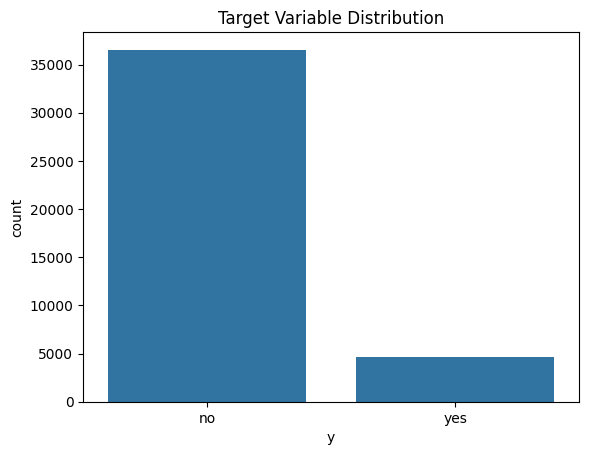

In [ ]:
# Visualizing the distribution of the target variable
sns.countplot(data=data, x='y')
plt.title('Target Variable Distribution')
plt.show()

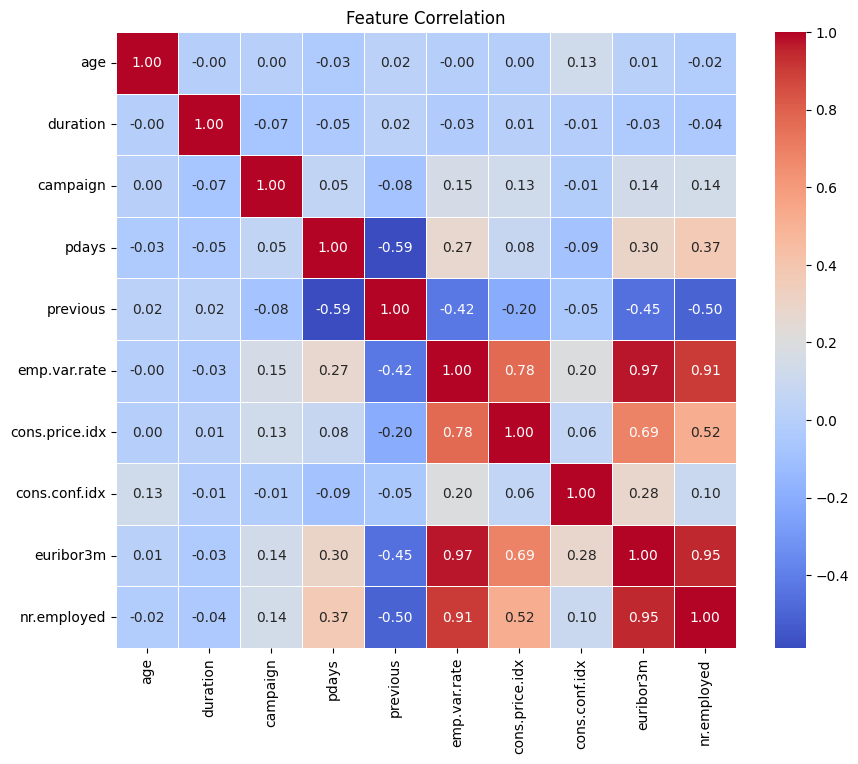

In [ ]:
# Ensure all non-numeric columns are excluded
numeric_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation')
plt.show()

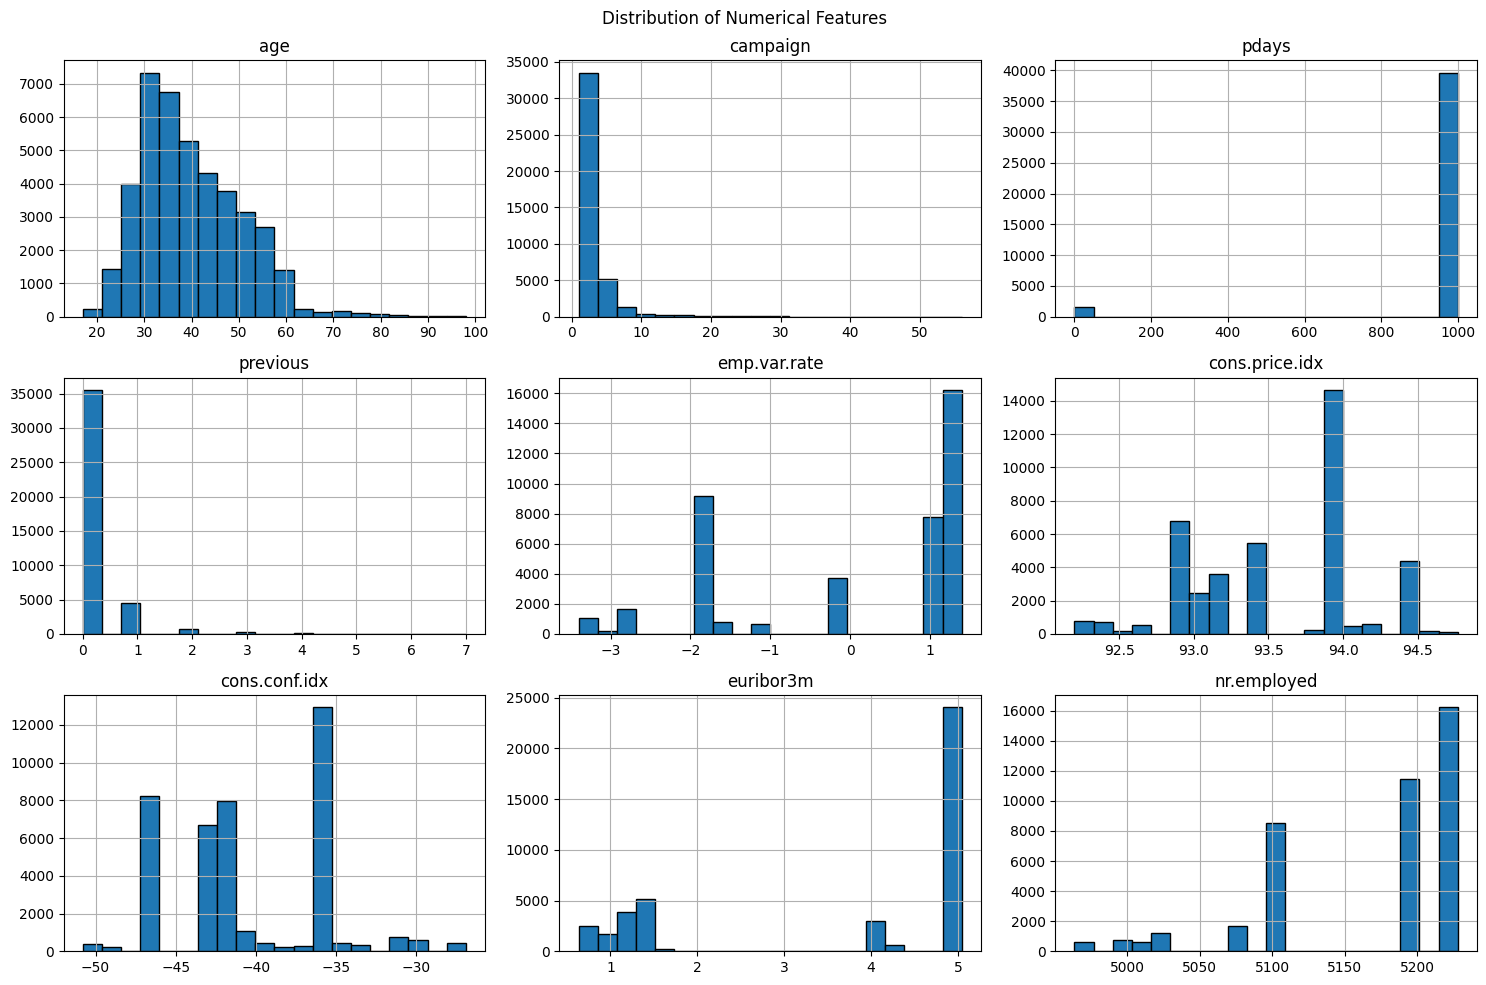

In [ ]:
# Visualizing the distribution of numerical columns
# Plotting histograms for all numerical columns
data[numerical_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

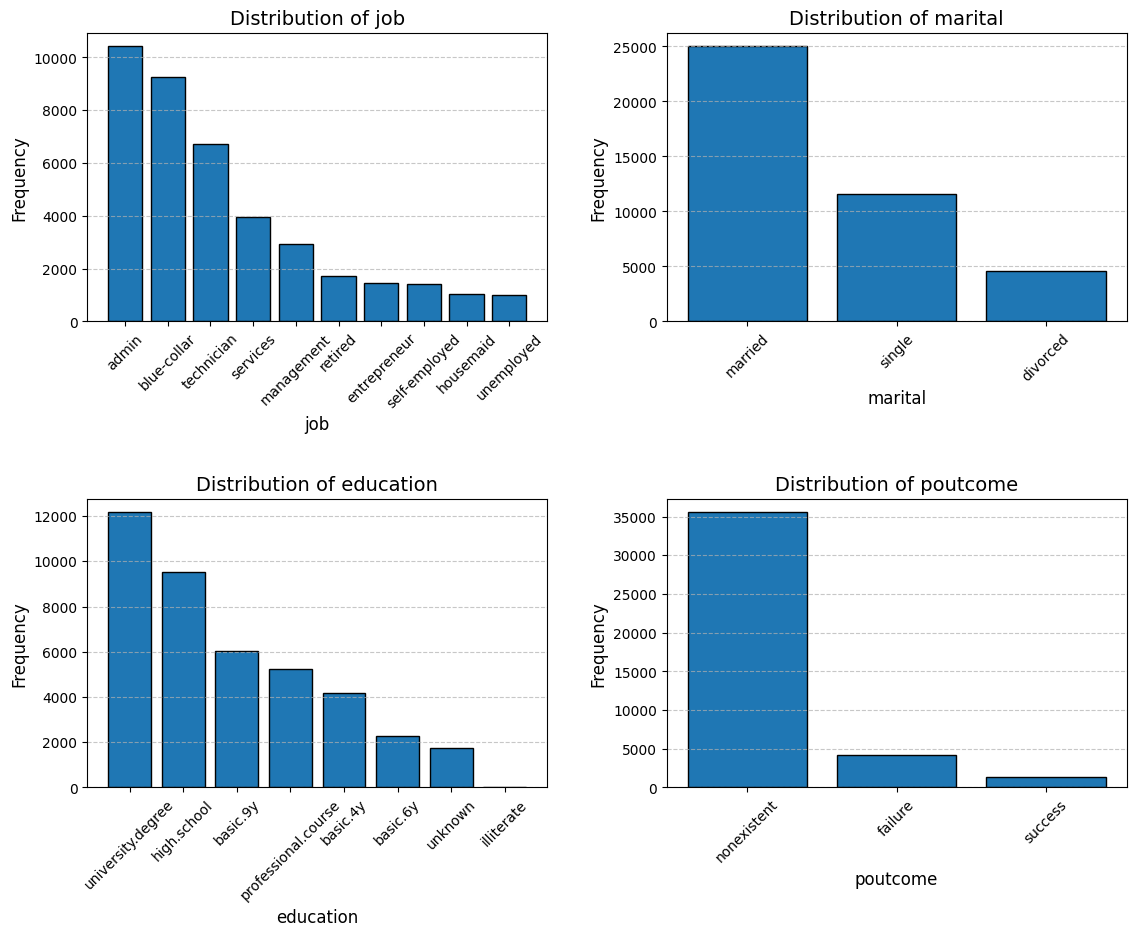

In [ ]:
# Visualizing the distribution of categorical columns
# Plotting histograms for all categorical columns
categorical_columns = [
    'job', 'marital', 'education', 'poutcome'
]

max_categories = 10

n_cols = 2
n_rows = len(categorical_columns) // n_cols + (len(categorical_columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    value_counts = data[column].value_counts()
    value_counts = value_counts.head(max_categories)

    axes[i].bar(value_counts.index, value_counts.values, edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()


# **Data Encoding**

**Encoding the non-ordinal categorical variables using one-hot encoding**

In [ ]:
#  One-hot encoding for non-ordinal categorical variables
non_ordinal_cols = ['job', 'marital', 'contact', 'poutcome', 'month', 'day_of_week']
data = pd.get_dummies(data, columns=non_ordinal_cols, drop_first=True)

**Encoding the ordinal categorical variables using labeled encoding**

In [ ]:
# Updated Label Encoding Map
label_encoding_map = {
    'default': {'no': 0, 'yes': 1},
    'education': {
       'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school': 5, 'professional.course': 6, 'university.degree': 7, 'unknown': 0
    },
    'housing': {'yes': 0, 'no': 1},
    'loan': {'no': 0, 'yes': 1},
}

# Apply label encoding
for column, mapping in label_encoding_map.items():
    data[column] = data[column].map(mapping)

# Display the first few rows to verify encoding
print(data.head())


   age  education  default  housing  loan  duration  campaign  pdays  \
0   56          2        0        1     0       261         1    999   
1   57          5        0        1     0       149         1    999   
2   37          5        0        0     0       226         1    999   
3   40          3        0        1     0       151         1    999   
4   56          5        0        1     1       307         1    999   

   previous  emp.var.rate  ...  month_jun  month_mar  month_may  month_nov  \
0         0           1.1  ...      False      False       True      False   
1         0           1.1  ...      False      False       True      False   
2         0           1.1  ...      False      False       True      False   
3         0           1.1  ...      False      False       True      False   
4         0           1.1  ...      False      False       True      False   

  month_oct  month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0     False      Fals

Excluding the 'duration' feature to avoid data leakage, as it directly depends on the outcome
and would not be available at the time of prediction in a real-world scenario

In [ ]:
# Excluding the 'duration' feature for realistic predictive modeling
data = data.drop(columns=['duration'])

**Excluding the default column since one case (" no ") dominates more than 90% of that column**

In [ ]:
# Excluding the duration column since more than 90% of the data in the column is dominated by the value "no"
data = data.drop(columns=['default'])

In [ ]:
# 7. Scaling numerical features
numerical_cols = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [ ]:
# Additional interaction features
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data['interaction_emp_cons'] = data['emp.var.rate'] * data['cons.price.idx']
data['interaction_nr_employed_conf'] = data['nr.employed'] * data['cons.conf.idx']

In [ ]:
# Calculate VIF
print("Calculating Variance Inflation Factor (VIF)...")
vif_data = pd.DataFrame()
vif_data['Feature'] = data_numeric.columns

# Correctly pass the numeric data (not just column names)
vif_data['VIF'] = [variance_inflation_factor(data_numeric.values, i) for i in range(data_numeric.shape[1])]

print(vif_data)

Calculating Variance Inflation Factor (VIF)...
          Feature        VIF
0             age   1.018794
1        campaign   1.033695
2           pdays   1.612615
3        previous   1.795700
4    emp.var.rate  33.065995
5  cons.price.idx   6.336849
6   cons.conf.idx   2.648641
7       euribor3m  64.334636
8     nr.employed  31.655857


In [ ]:
# Remove highly collinear features
data_reduced = data.drop(columns=['emp.var.rate', 'euribor3m', 'nr.employed'])

In [ ]:
# Step 6: Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data[numerical_cols])
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PCA Components: {explained_variance}')

Performing PCA...
Explained Variance by PCA Components: [0.43263736 0.15072965]


In [ ]:
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
print("PCA Result:")
print(pca_df.head())

PCA Result:
        PC1       PC2
0  1.269356 -0.884414
1  1.269210 -0.908907
2  1.272118 -0.419050
3  1.271682 -0.492528
4  1.269356 -0.884414


In [ ]:
# 8. Encoding the target variable (y)
data['y'] = data['y'].map({'yes': 1, 'no': 0})

In [ ]:
# Splitting data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']

In [ ]:
# 9. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Balancing the Target Variable Column**

In [ ]:
# Analyzing the distribution of the target variable
y_train.value_counts(normalize=True)

,proportion
y,
0,0.888646
1,0.111354


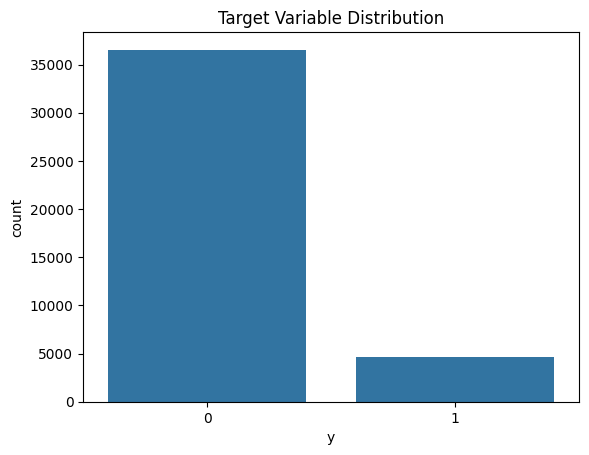

In [ ]:
# Visualizing the distribution of the target variable
sns.countplot(data=data, x='y')
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
# Import necessary modules
from sklearn.utils.validation import validate_data
from imblearn.over_sampling import SMOTE
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Handling imbalanced dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

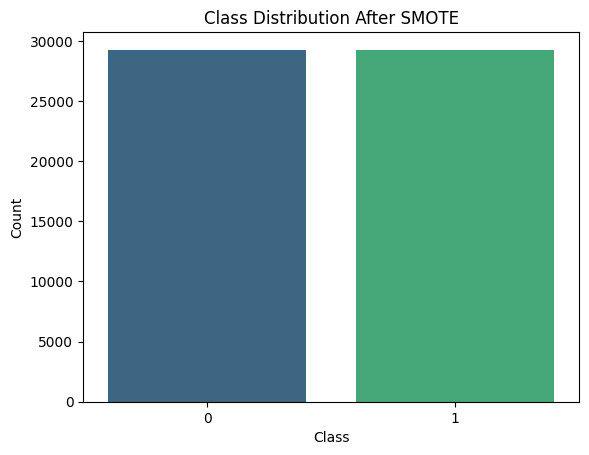

In [ ]:
# Plot class distribution after SMOTE
sns.countplot(x=y_train_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# **Building Model**

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

from sklearn.neural_network import MLPClassifier

# Compute class weights
class_weights = {0: len(y_train) / (2 * (y_train == 0).sum()),
                 1: len(y_train) / (2 * (y_train == 1).sum())}

# Initialize Neural Network with adjusted class weights
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42, solver='adam')

# Manually apply class weights
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on the target variable
nn_model.fit(X_train_resampled, y_train_resampled)


MLPClassifier(max_iter=500, random_state=42)

In [ ]:
# Random Forest Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Neural Network Predictions
y_pred_nn = nn_model.predict(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)[:, 1]

In [ ]:
# Accuracy and Classification Report for Random Forest
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Accuracy and Classification Report for Neural Network
print("Neural Network Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

Random Forest Model Evaluation:
Accuracy: 0.8705682370082565

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      7265
           1       0.44      0.39      0.42       971

    accuracy                           0.87      8236
   macro avg       0.68      0.66      0.67      8236
weighted avg       0.86      0.87      0.87      8236

Neural Network Model Evaluation:
Accuracy: 0.8235794074793589

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      7265
           1       0.31      0.40      0.35       971

    accuracy                           0.82      8236
   macro avg       0.61      0.64      0.62      8236
weighted avg       0.85      0.82      0.83      8236



In [ ]:
# ROC-AUC Scores
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

print(f"Random Forest ROC-AUC: {roc_auc_rf}")
print(f"Neural Network ROC-AUC: {roc_auc_nn}")

Random Forest ROC-AUC: 0.7642315377184037
Neural Network ROC-AUC: 0.7063656074331809


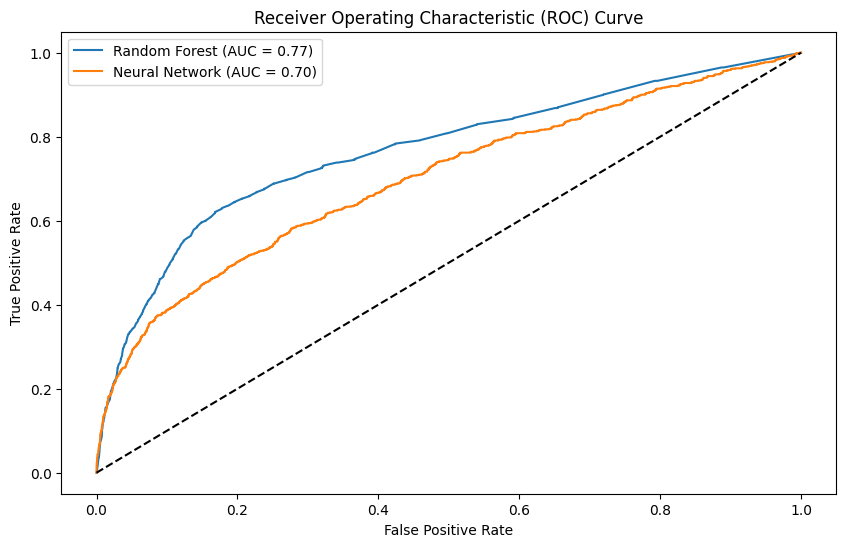

In [ ]:
# Plotting ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()